# Use different parameterisations of the MRP and check how well they perform

In this example, we use the framework of the ``reparameterise`` module to check the performance of some of the different parameterizations of the MRP. The idea is to set up large samples of halos with the same MRP parameters at various truncation masses, and check the covariance of the parameters at the solution in each case, for different parameterisations. Then compare the covariance in each case.

**Figure from this example is found in MRP appendix B**

## Create Data

First we're going to set some parameters which we'll use throughout. These typify what we expect the HMF to be around a redshift of 0 (roughly!).

In [2]:
# Imports
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os

from mrpy.extra import reparameterise as repar
from mrpy import MRP
from mrpy.fitting.fit_sample import SimFit

In [7]:
fig_folder=""

In [3]:
# MRP parameters
hs = 14.5
alpha = -1.85
beta = 0.72
mmins = [10.0,10.5,11.0,11.5,12.0,12.5,13.0]
V = 1

nbar = 1e6

# Number of samples
Nreal = 20

# Parameters defining outcomes
maxj = 1

In [6]:
force_recalc = False

if os.path.exists("parameterisations/data.npz") and not force_recalc:
    f = np.load("parameterisations/data.npz")
    gg2_mean = f['gg2_mean']
    gg3_mean = f['gg3_mean']
    ht_mean =  f['ht_mean']
    gg2_sd   = f['gg2_sd']
    gg3_sd   = f['gg3_sd']
    ht_sd    = f['ht_sd']

else:
    # Instantiate our final result arrays
    gg2 = np.zeros((Nreal,len(mmins),3,2))
    gg3 = np.zeros((Nreal,len(mmins),3,2))
    ht = np.zeros((Nreal,len(mmins),3,2))

    np.random.seed(1010)

    
    for im,mmin in enumerate(mmins):
        mm = MRP(None, logHs=hs, alpha=alpha,beta=beta, norm=0, log_mmin=mmin)
        lnA = np.log(nbar/mm.nbar) 
        
        for i in range(Nreal):
            
            # The following checks if there are any oddities with the covariance.
            # Since the covariance is derived numerically from the analytic hessian,
            # if the hessian is extremely correlated, the matrix inversion can fail.
            # In such a case, we re-draw the samples.
            do = True
            j=0
            while do and j<maxj:
                logm = np.log10(mm.stats.rvs(np.random.poisson(nbar)))
                
                #Fit the data
                fit = SimFit(10**logm, mmin=10**mmin).run_downhill(hs,alpha,beta,lnA)[0].x
                
                gg2c = repar.GG2Sample(logm=logm,log_mmin=mmin,logHs=fit[0],alpha=fit[1],beta=fit[2],lnA=fit[3])

                gg2[i,im,:,0] = np.sqrt(np.diag(gg2c.cov_ratio)[:3]) * gg2c.theta_T()/gg2c.p_T()
                do = np.any(np.logical_or(np.isnan(gg2[i,im,:,0]),np.isinf(gg2[i,im,:,0])))
                j+=1
            if j>maxj:
                print "ITERATION %s ON MMIN=%s HAD NANS: "%(i,mmin)

            # GG2 results
            gg2[i,im,:,1] = gg2c.corr_ratio[0,1],gg2c.corr_ratio[0,2],gg2c.corr_ratio[1,2]
            
            # GG3 results
            gg3c = repar.GG3Sample(logm=logm,log_mmin=mmin,logHs=fit[0],alpha=fit[1],beta=fit[2],lnA=fit[3])
            gg3[i,im,:,0] = np.sqrt(np.diag(gg3c.cov_ratio)[:3])* gg3c.theta_T()/gg3c.p_T()
            gg3[i,im,:,1] = gg3c.corr_ratio[0,1],gg3c.corr_ratio[0,2],gg3c.corr_ratio[1,2]
            
            # HT results
            htc = repar.HTSample(logm=logm,log_mmin=mmin,logHs=fit[0],alpha=fit[1],beta=fit[2],lnA=fit[3])
            ht[i,im,:,0] = np.sqrt(np.diag(htc.cov_ratio)[:3])* htc.theta_T()/htc.p_T()
            ht[i,im,:,1] = htc.corr_ratio[0,1],htc.corr_ratio[0,2],htc.corr_ratio[1,2]

    # Take the mean over the first axis
    gg2_mean = np.nanmean(gg2,axis=0)
    gg3_mean = np.nanmean(gg3,axis=0)
    ht_mean = np.nanmean(ht,axis=0)
    gg2_sd = np.nanstd(gg2,axis=0)
    gg3_sd = np.nanstd(gg3,axis=0)
    ht_sd = np.nanstd(ht,axis=0)

    # Save the data
    np.savez("parameterisations/data.npz",gg2_mean=gg2_mean,gg3_mean=gg3_mean,
             ht_mean=ht_mean,gg2_sd=gg2_sd,gg3_sd=gg3_sd,ht_sd=ht_sd)

## Make  a Plot

We want to make a plot which shows the relative variance/covariance in parameters of the different forms over the different truncation masses. In the top panel we'll plot the difference in variance of the parameters. The smaller the better. In the bottom panel, we'll plot the correlation of the parameter combinations. In this case, the closer to 0 the better. In each case, what is plotted is the *ratio* of the value to that in the case of the MRP. We notate the transformation parameters as $\mu, \nu, \delta$, and compare directly to $\log \mathcal{H}_\star, \alpha, \beta$.

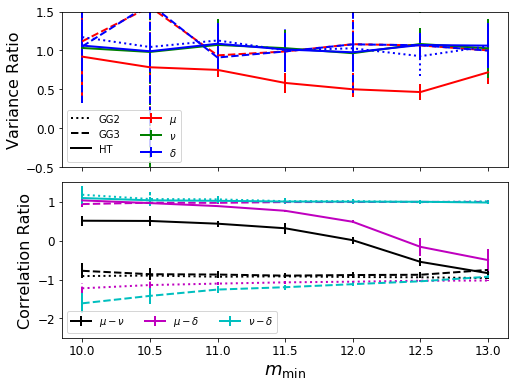

In [8]:
fig,ax=plt.subplots(2,1,sharex=True,figsize=(8,6))

ax[0].plot([np.nan],[np.nan],label="GG2",color="k",ls=":",lw=2)
ax[0].plot([np.nan],[np.nan],label="GG3",color="k",ls="--",lw=2)
ax[0].plot([np.nan],[np.nan],label="HT",color="k",lw=2)

for ip,par in enumerate([r"$\mu$",r"$\nu$",r"$\delta$"]):
    col1=['r','g','b'][ip]
    eb = ax[0].errorbar(mmins,gg2_mean[:,ip,0],gg2_sd[:,ip,0],ls=':',color=col1,lw=2)
    eb[-1][0].set_linestyle(":")
    eb=ax[0].errorbar(mmins,gg3_mean[:,ip,0],gg3_sd[:,ip,0],ls="--",color=col1,lw=2)
    eb[-1][0].set_linestyle("--")
    ax[0].errorbar(mmins,ht_mean[:,ip,0],ht_sd[:,ip,0],color=col1,label=par,lw=2)

for ip, cmb in enumerate([r"$\mu-\nu$",r"$\mu-\delta$",r"$\nu-\delta$"]):
    col2=['k','m','c'][ip]
    eb=ax[1].errorbar(mmins,gg2_mean[:,ip,1],gg2_sd[:,ip,1],ls=':',color=col2,lw=2)        
    eb[-1][0].set_linestyle(":")
    ax[1].errorbar(mmins,gg3_mean[:,ip,1],gg3_sd[:,ip,1],ls="--",color=col2,lw=2)
    eb[-1][0].set_linestyle("--")
    ax[1].errorbar(mmins,ht_mean[:,ip,1],ht_sd[:,ip,1],label=cmb,color=col2,lw=2)

ax[0].set_ylim((-0.5,1.5))
ax[0].legend(loc=0,ncol=2)
ax[1].legend(loc=0,ncol=3)
plt.subplots_adjust(hspace=0.1)
ax[1].set_ylim((-2.5,1.5))
ax[-1].set_xlabel(r"$m_{\rm min}$",fontsize=18)

for i in range(2):
    ax[i].tick_params(axis='both', which='major', labelsize=12)
    
ax[0].set_ylabel("Variance Ratio",fontsize=16)
ax[1].set_ylabel("Correlation Ratio",fontsize=16)

#Save for the paper!
if fig_folder:
    plt.savefig(join(fig_folder,"reparameterisations_vs_mmin.pdf"))